In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score, precision_score
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [63]:
## checando se reconhece a gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [64]:
training_percentual = 0.7
matrizes = []
history = []
recall = []
f1score = []
precision = []
images = np.load('images.npy')
labels = np.load('labels.npy')

In [65]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size = training_percentual)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, train_size = 0.8)

In [6]:
X_train.shape

(3135, 300, 300, 3)

In [67]:
X_test.shape

(1681, 300, 300, 3)

In [8]:
y_val.shape

(784,)

In [9]:
def buildModel(input_shape=(300, 300, 3), num_classes=1):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.001)  # Você pode ajustar a taxa de aprendizado conforme necessário
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [11]:
checkpoint = ModelCheckpoint(
    filepath='D:\\Trabalho-ReconhecimentoPadroes\\models\\best_model.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5, 
    patience=5, 
    min_lr=1e-6, 
    verbose=1)

early_stopping = EarlyStopping(
    monitor="val_loss", 
    patience=30, 
    verbose=1)

In [10]:
model = buildModel()

In [12]:
H = model.fit(X_train, y_train, 
                batch_size=8,
                epochs=100,
                validation_data=(X_val, y_val), 
                verbose=1, 
                callbacks=[checkpoint, reduce_lr])

Epoch 1/100
392/392 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8676
Epoch 1: val_loss improved from inf to 10.41280, saving model to D:\Trabalho-ReconhecimentoPadroes\models\best_model.hdf5
392/392 [==============================] - 74s 148ms/step - loss: 0.3435 - accuracy: 0.8676 - val_loss: 10.4128 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 2/100
392/392 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9174
Epoch 2: val_loss improved from 10.41280 to 0.06571, saving model to D:\Trabalho-ReconhecimentoPadroes\models\best_model.hdf5
392/392 [==============================] - 52s 133ms/step - loss: 0.2321 - accuracy: 0.9174 - val_loss: 0.0657 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 3/100
392/392 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9432
Epoch 3: val_loss did not improve from 0.06571
392/392 [==============================] - 50s 128ms/step - loss: 0.1769 - accuracy: 0.9432 - val_loss: 0.1012 - val_ac

In [12]:
model.load_weights('D:\\Trabalho-ReconhecimentoPadroes\\models\\best_model.hdf5')

In [14]:
def threshold(y_pred):
    result = np.where(y_pred > 0.5, 1, 0)
    return result

In [16]:
y_pred = model.predict(X_test)
y_pred = threshold(y_pred)
# y_pred = np.argmax(y_pred, axis=1)
# for i in y_pred:
#     print(i)

# y_test = np.argmax(y_test, axis=0)
# print(y_test)

# draw_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

53/53 [==============================] - 5s 87ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       804
           1       1.00      0.98      0.99       877

    accuracy                           0.99      1681
   macro avg       0.99      0.99      0.99      1681
weighted avg       0.99      0.99      0.99      1681



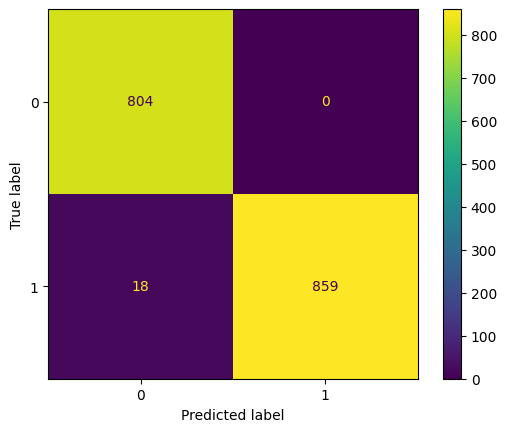

In [22]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

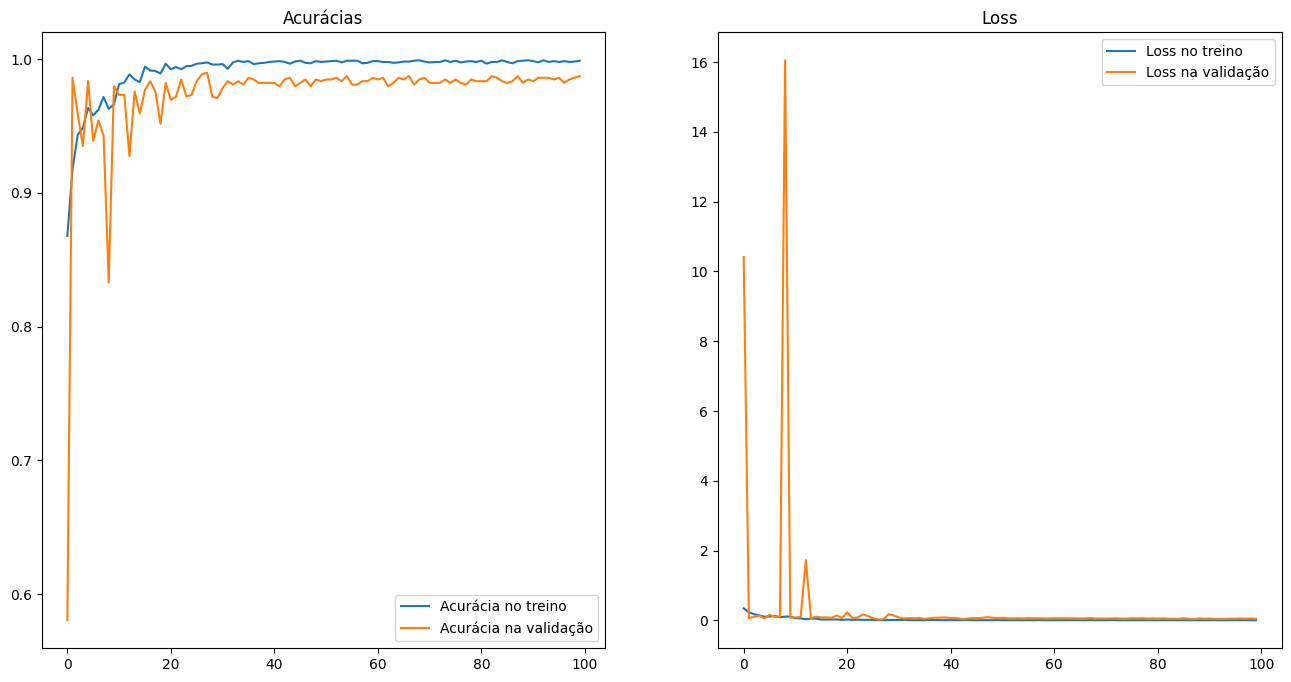

In [39]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(range(100), acc, label='Acurácia no treino')
plt.plot(range(100), val_acc, label='Acurácia na validação')
plt.legend()
plt.title("Acurácias")

plt.subplot(1, 2, 2)
plt.plot(range(100), loss, label='Loss no treino')
plt.plot(range(100), val_loss, label='Loss na validação')
plt.legend()
plt.title("Loss")

plt.show()

In [81]:
def dividir_em_janelas(image_path):
    imagem = cv2.imread(image_path)
    
    if imagem is None:
        raise ValueError("A imagem não pôde ser lida.")
    
    altura, largura, _ = imagem.shape
    tamanho_da_janela = 300
    janelas = []

    for x in range(0, largura, tamanho_da_janela):
        for y in range(0, altura, tamanho_da_janela):
            caixa = (x, y, x + tamanho_da_janela, y + tamanho_da_janela)
            janela = imagem[y:y+tamanho_da_janela, x:x+tamanho_da_janela]
            
            # Verifique se a janela tem dimensão de 300x300.
            if janela.shape == (tamanho_da_janela, tamanho_da_janela, 3):
                janelas.append(janela)

    return np.array(janelas)

In [68]:
def cortar_imagem(image_path):
    imagem = Image.open(image_path).convert("RGB")
    largura, altura = imagem.size
    janelas = []

    for x in range(0, largura, 300):
        for y in range(0, altura, 300):
            caixa = (x, y, x + 300, y + 300)
            janela = imagem.crop(caixa)
            if janela.width == 300 and janela.height == 300:
                janelas.append(np.array(janela))

    return np.array(janelas)

In [82]:
def check_noise(image_path, model):
    # image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    # if image is None:
    #     raise ValueError("A imagem não pôde ser lida.")
    windows = dividir_em_janelas(image_path)
    print("Número de janelas da imagem", windows.shape)

    for i, window in enumerate(windows):
        plt.imshow(window, cmap='gray')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    predict = model.predict(windows)
    # predict = threshold(predict)
    print('predição', predict)
    # noise_percent = (np.sum(predict) / len(predict)) * 100
    # print("Porcentagem de janelas com ruído", noise_percent)
    # if noise_percent > 70:
    #     return True
    # else:
    #     return False

Número de janelas da imagem (1, 300, 300, 3)


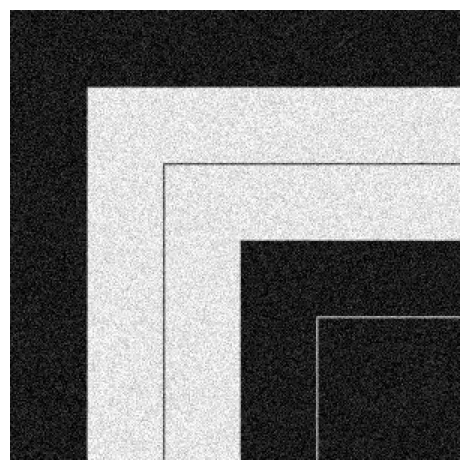

1/1 [==============================] - 0s 37ms/step
predição [[2.0036543e-06]]
Imagem tem ruído? None


In [83]:
result = check_noise(
    'D:\\Trabalho-ReconhecimentoPadroes\\teste\\teste-low.png',
    model
)
print("Imagem tem ruído?", result)